In [1]:
import numpy as np
import pandas as pd
import pickle
import os

from tqdm import tqdm
from script.generate_multivariate_samples import generate_multivariate_samples

import numpy as np
import plotly.graph_objs as go
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from script.curate_training_test_data import curate_training_test_data


In [10]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24')) & (df_all['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

<Axes: xlabel='Date'>

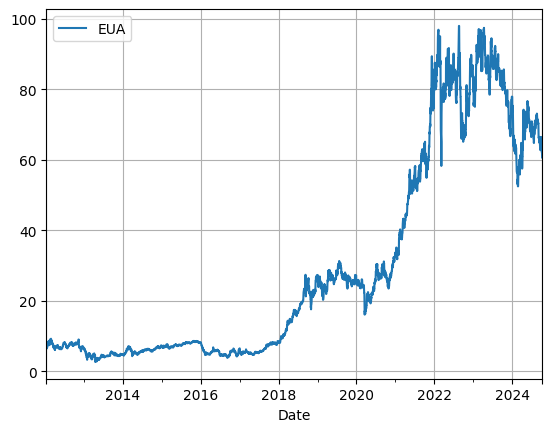

In [9]:
df_all.plot(kind = 'line', x = 'Date', y ='EUA', grid ='on')

<Axes: ylabel='Frequency'>

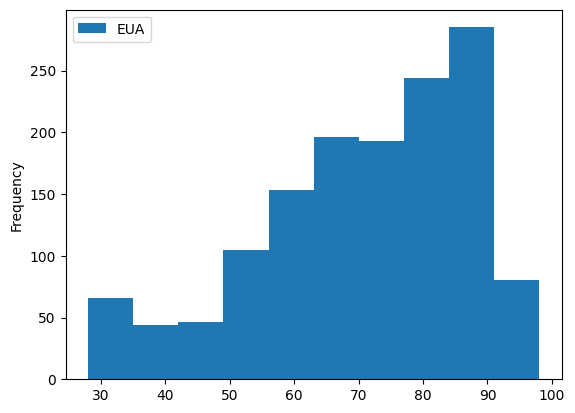

In [11]:
df_all.plot(kind = 'hist', y = 'EUA')

In [4]:
# Assuming df_all is your DataFrame
fig = px.line(df_all, x='Date', y='EUA', title='EUA Over Time')
# Show the figure
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [9]:
df_all = df_all.resample('W', on = 'Date').mean()

In [ ]:
df_all

In [6]:
def train_lstm(model, checkpoint_path, X_train, y_train):
    try:
        model.load_weights(checkpoint_path) 
        with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'rb') as f:
            history = pickle.load(f)
    except:
        def lr_scheduler(epoch, lr):
        # if epoch < 10:
            return lr
        # Learning rate scheduler callback
        lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

        checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss', 
                                    save_best_only=True,
                                    mode='min',  
                                    verbose=1)

        early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

        history = model.fit(X_train, y_train, epochs=1000, batch_size=128, 
                            validation_split=0.05,
                            verbose=1, callbacks=[checkpoint, lr_scheduler_callback, early_stopping])# ,early_stopping]) 
        
        with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'wb') as f:
            pickle.dump(history, f)
    return history


In [ ]:
predictors_lst = ['EUA', 'Oil', 'Coal', 'NG']
test_date = '2024-08-01'
folder_name = "result_folder_no_misc_v2"
modeltype='lstm'

# save original EUA & date
original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values

for sequence_length in [i for i in range(3, 61)]:
    last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
    X_train, y_train, X_test, y_test, scaler = curate_training_test_data(df_all, 
                                                                         flatten = False,
                                                                         sequence_length=sequence_length,
                                                                         test_date = test_date,
                                                                         predictors_lst = predictors_lst )

    checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.keras"
    model = generate_lstm(X_train, predictors_lst)
    history = train_lstm(model, checkpoint_path, X_train, y_train)
    # model.load_weights(checkpoint_path) 

    # plot loss curves 
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.savefig(f'{folder_name}/{modeltype}_LossCurve_ts_{sequence_length}.pdf')
    plt.close()

    # accuracy plot
    train_predictions = model.predict(X_train, verbose = 0);
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    test_predictions = model.predict(X_test, verbose = 0);
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)

    ground_truth_train = scaler.inverse_transform(y_train)
    ground_truth_test = scaler.inverse_transform(y_test)

    plt.figure(figsize = (13,13))
    for i, feature in enumerate(predictors_lst):
        plt.subplot(len(predictors_lst)//3 + 1 if len(predictors_lst)%3 !=0 else len(predictors_lst)//3, 3, i+1)
        plt.scatter(ground_truth_train[:,i],train_predictions_rescaled[:,i], label = 'train')
        plt.scatter(ground_truth_test[:,i],test_predictions_rescaled[:,i], label = 'test')
        plt.plot([min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], 
                [min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], color='red', label='1:1 Line')
        
        r2_train = r2_score(ground_truth_train[:,i],train_predictions_rescaled[:,i])
        r2_test = r2_score(ground_truth_test[:,i],test_predictions_rescaled[:,i])
        plt.title(f"{feature} - train: {r2_train:.5f} / test: {r2_test:.5f}")
        plt.legend()
        plt.grid('on')
        plt.xlabel('ground truth')
        plt.ylabel('prediction')
    plt.tight_layout()
    plt.savefig(f'{folder_name}/{modeltype}_acc_ts_{sequence_length}.pdf')
    plt.close()

    # get RMSE:
    rel_erorrs = []
    for i in range(test_predictions_rescaled.shape[1]):
        prediction = test_predictions[:, i]
        ground_truth = y_test[:,i]
        rel_error = np.mean(np.sqrt(((prediction-ground_truth)**2)))
        print(predictors_lst[i])
        print(rel_error)
        rel_erorrs.append(rel_error)




    num_of_prediction = 30*6
    corr = df_all[predictors_lst].corr()
    for factor, num_ensemble in zip([0, 1.0], [2, 100]):
        rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
        next_predictions = []
        current_input = X_train[-1]
        current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
        for iter_ in tqdm(range(num_of_prediction)):
            next_prediction = model.predict(current_input, verbose = 0)
            error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
            next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
            next_predictions.append(next_prediction)
            current_input = np.concatenate([current_input, 
                                            np.expand_dims(next_prediction,1)], axis=1)
        next_predictions = np.array(next_predictions)
        future_dates = [last_train_date + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
        ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])


        # Calculate mean, P10, and P90 of predictions
        mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
        P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
        P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
        P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

        # Create the plot
        plt.figure(figsize=(10, 6))

        # Plot historical EUA prices
        plt.plot(dates, original_EUA, label='Historical EUA Price', color='black')

        # Plot all realizations
        for realization in ensemble_future_predictions[:, :, 0].T:
            plt.plot(future_dates, realization, color='gray', alpha=0.3)

        # Plot P10 and P90 percentile predictions
        plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
        plt.plot(future_dates, P90, color='green', linestyle='-')
        # Plot mean of future predictions
        plt.plot(future_dates, P50, label='Median of Predictions', color='red')
        plt.plot(df_all[df_all['Date']>test_date]['Date'],
                    df_all[df_all['Date']>test_date]['EUA'],
                    color = 'blue',
                    label = 'Future EUA Price' 
                    )


        # Customize the plot
        plt.title('EUA Price Prediction for the Next 24 Months')
        plt.xlabel('Date')
        plt.ylabel('EUA Price')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.savefig(f"{folder_name}/{modeltype}_timeplot_ts_{sequence_length}_factor_{str(factor).replace('.','_')}.pdf")
        plt.close()

    record = {}
    with open(f'{folder_name}/{modeltype}_record_ts_{sequence_length}.txt', 'w') as f:
        # report metrics
        for i, feature in enumerate(predictors_lst):
            r2_train = r2_score(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            r2_test = r2_score(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            mse_train = mean_squared_error(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            mse_test  = mean_squared_error(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            mae_train = mean_absolute_error(ground_truth_train[:,i],train_predictions_rescaled[:,i])
            mae_test  = mean_absolute_error(ground_truth_test[:,i],test_predictions_rescaled[:,i])
            f.write(f'{feature}\n')
            f.write(f'r2(train): {r2_train}\n')
            f.write(f'r2(test): {r2_test}\n')
            f.write(f'mse(train): {mse_train}\n')
            f.write(f'mse(test): {mse_test}\n')
            f.write(f'mae(train): {mae_train}\n')
            f.write(f'mae(test): {mae_test}\n')
            f.write('---------------------------\n')
            record['feature'] = {"r2_train":r2_train, 
                                "r2_test": r2_test,
                                "mse_train": mse_train, 
                                "mse_test": mse_test, 
                                "mae_train": mae_train, 
                                "mae_test": mae_test,}
    # save metric as dictionary
    with open(f'{folder_name}/{modeltype}_record_ts_{sequence_length}.pkl', 'wb') as f:
        pickle.dump(record, f)
    # Save the best model



In [ ]:
for factor in [1, 2, 3]:
    num_of_prediction = 30*12
    num_ensemble = 100
    rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
    corr = df_all[predictors_lst].corr()

    next_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
    for iter_ in tqdm(range(num_of_prediction)):
        next_prediction = model.predict(current_input, verbose = 0)
        error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
        next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
        next_predictions.append(next_prediction)
        current_input = np.concatenate([current_input[:,1:], 
                                        next_prediction.reshape(next_prediction.shape[0],1,
                                                                next_prediction.shape[1])], axis=1)
    next_predictions = np.array(next_predictions)
    future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
    ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])
    # Calculate mean, P10, and P90 of predictions
    mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
    P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
    P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
    P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot historical EUA prices
    plt.plot(dates, original_EUA, label='Historical EUA Price', color='blue')

    # Plot all realizations
    for realization in ensemble_future_predictions[:, :, 0].T:
        plt.plot(future_dates, realization, color='gray', alpha=0.3)

    # Plot P10 and P90 percentile predictions
    plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
    plt.plot(future_dates, P90, color='green', linestyle='-')
    # Plot mean of future predictions
    plt.plot(future_dates, P50, label='Median of Predictions', color='red')


    # Customize the plot
    plt.title(f'EUA Price Prediction for the Next 24 Months - factor of {factor}')
    plt.xlabel('Date')
    plt.ylabel('EUA Price')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
num_of_prediction = 30*24
num_ensemble = 3

ensemble_future_predictions = []
for en in range(num_ensemble):
    future_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    for i in tqdm(range(num_of_prediction)):
        current_input_scaled = np.reshape(current_input, (1, sequence_length, current_input.shape[1]))
        next_prediction = model.predict(current_input_scaled, verbose = 0)
        for j in range(train_predictions_rescaled.shape[1]):
            next_prediction[0, j] *= (1+np.random.normal(0, rel_erorrs[j]))
        future_predictions.append(next_prediction[0])  
        current_input = np.concatenate([current_input[1:], [next_prediction[0]]], axis=0)
    ensemble_future_predictions.append(scaler.inverse_transform(np.array(future_predictions)))

ensemble_future_predictions= np.array(ensemble_future_predictions)


# future_predictions_original = scaler.inverse_transform(future_predictions)
future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]

In [ ]:

# Create traces for each plot
trace1 = go.Scatter(x=dates, y=original_EUA, mode='lines', name='Historical EUA Price', 
                    line=dict(color='blue'))

trace2 = go.Scatter(x=future_dates, y=ensemble_future_predictions[0,:,0], mode='lines', 
                    name='Predicted EUA Price_1', 
                    line=dict(color='red'))

trace3 = go.Scatter(x=future_dates, y=ensemble_future_predictions[1,:,0], mode='lines', 
                    name='Predicted EUA Price_2', 
                    line=dict(color='purple'))

trace4 = go.Scatter(x=future_dates, y=ensemble_future_predictions[2,:,0], mode='lines', 
                    name='Predicted EUA Price_3', 
                    line=dict(color='orange'))

trace5 = go.Scatter(x=train_dates[-train_predictions_rescaled.shape[0]:], 
                    y=train_predictions_rescaled[:, 0], mode='lines+markers', 
                    name='Train Predicted EUA Price', marker=dict(color='green', size=4), 
                    line=dict(color='green'))

# Layout for the plot
layout = go.Layout(
    title='EUA Price Prediction for the Next 24 Months',
    xaxis=dict(title='Date'),
    yaxis=dict(title='EUA Price'),
    legend=dict(x=0, y=1, traceorder='normal'),
    height=600,
    width=1000
)

# Create the figure with the traces
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

# Show the figure (interactive plot)
fig.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dates, original_EUA, 'b', label='Historical EUA Price')  # 원본 EUA 데이터
# plt.plot(train_dates, scaler.inverse_transform(test_data_scaled)[:, 0], 'skyblue', label='Test EUA Price')  # 테스트 데이터
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'red', linewidth = 0.1, label = 'real_1')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'purple', linewidth = 0.1, label = 'real_2')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'yellow', linewidth = 0.1, label = 'real_3')
plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 24 Months')
plt.legend()
plt.show()